<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多层感知机
> 最简单的深度网络称为多层感知机，他们由多层神经元组成，每一层都与下面一层（从中接受输入）和上面一层（反过来影响当前层的神经元）完全相连。

In [ ]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.4 MB/s 


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

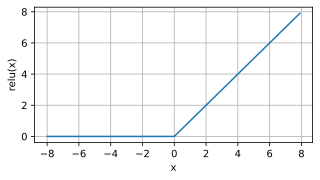

In [ ]:
#激活函数之Relu，最受欢迎的激活函数，因为它实现简单，给定元素x，Relu函数被定义为该元素与0的最大值

x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(),y.detach(),'x','relu(x)',figsize=(5,2.5))

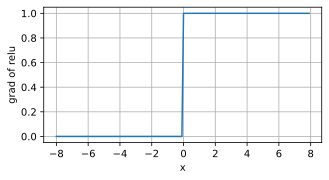

In [ ]:
#下面绘制Relu函数的导数
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of relu',figsize=(5,2.5))

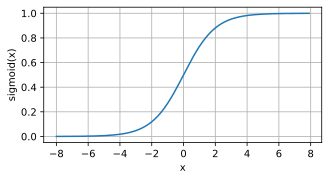

In [ ]:
#sigmoid函数，讲输入变换为区间（0，1）上的输出，通常称他为挤压函数。在二分类问题的概率问题上，sigmoid函数被广泛使用。
#下面绘制sigmoid函数，注意当输入接近0时，sigmoid函数接近线性变换
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(),'x','sigmoid(x)',figsize=(5,2.5))

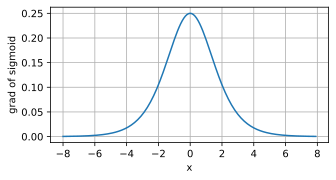

In [ ]:
#sigmoid函数另一个优点是：求导好求，y=sigmoid(x)=1/(1+exp(-x))，y'=y(1-y)
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of sigmoid',figsize=(5,2.5))

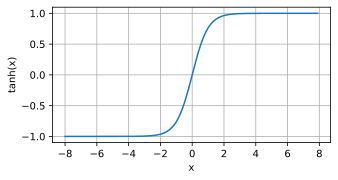

In [ ]:
#tanh函数，这个函数将其输入压缩转换到区间(-1，1)上，定义如下：tanh(x)=(1-exp(-2x))/(1+exp(-2x))
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(),'x','tanh(x)',figsize=(5,2.5))  #它在输入接近0时，tanh函数接近线性变换，类似与sigmoid函数，不同的是tanh函数是关于原点对称

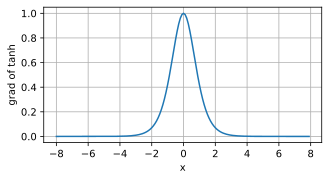

In [ ]:
#下面绘制tanh函数的导数，y'=1-y^2，在接近0的时候，他的导数与sigmoid函数的导数类似，输入在任一方向上越远离0点，导数越接近0
x.grad.data.zero_()
y.backward(torch.ones_like(x))
d2l.plot(x.detach(),x.grad,'x','grad of tanh',figsize=(5,2.5))

## 小结
> 多层感知机在输出层和输入层之间增加一个或多个全连接的隐藏层，并经过激活函数转换隐藏层的输出。


## 多层感知机的从零实现

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

In [19]:
def load_data_fashion_mnist(batch_size, resize=None): #这个函数将上面的那些整合，用于获取和读取Fashion-MNIST数据集，他返回训练集和验证集的数据迭代器
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""    #其中还有一个可选参数，用将图像的大小调整为另一种形状
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [20]:
#获取训练集，验证集
batch_size = 256
trainer_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [22]:
#初始化模型参数
num_inputs, num_outputs, num_hiddens = 784,10,256 #784个输入特征，10个类的简单分类数据集，256个隐藏单元

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))

W2 = nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1, b1, W1, b2]  #对于每一层我们都要记录一个权重矩阵和一个偏移向量，并且为这些参数的损失的梯度分配内存

In [23]:
#定义一个激活函数，这里我们使用relu
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(X,a)   #这个relu函数并不是直接调用的，我们来实现这个relu函数。

In [24]:
#模型
def net(X):
  X = X.reshape((-1,num_inputs))
  H = relu(X@W1 + b1)  #这里@表示矩阵乘法
  return (H@W2 + b2)

In [25]:
#损失函数，这里使用交叉熵损失
loss = nn.CrossEntropyLoss()

AssertionError: ignored

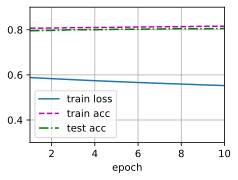

In [28]:
#训练
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net,trainer_iter,test_iter,loss,num_epochs,updater)